# Adversarial Training: Training the Neural Netowrk Against Adversarial Attacks

## Imports and GPU Check

In [3]:
#imports
#Main Library (Actual Neural Network Part)
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import neural_structured_learning as nsl

# #Helper Libraries (in order to interpret and view the data)
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Prints if a GPU is detected by the TensorFlow system
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


## Importing, Validating, and Scaling the MNIST Dataset

In [5]:
#importing the MNIST dataset from tensorflow
from tensorflow.keras.datasets import mnist 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

[3]
[2]
[1]
[18]
[4]
[8]
[11]
[0]
[61]
[7]


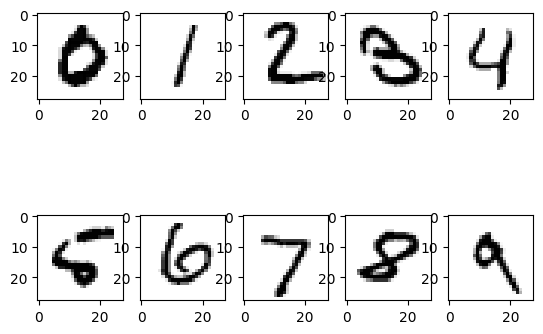

In [6]:
#validating the data (making sure this is the data I want)
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_test == i)[0]
    print(im_idx)
    plottable_image = np.reshape(X_test[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

In [7]:
#checking the format of the data because I want the data to be scaled from 0 to 1
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [8]:
#scaling the data from 0 to 1 as float (decimal) numbers
X_train, X_test = X_train / 255.0, X_test / 255.0

## Creation of Adversarial Model (model) and loading of Base Model (base_model)

### Creation of Adversarial Model

In [9]:
#creating the model - Sequential 
model = models.Sequential()
#first conv. layer and pooling layer
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
#second conv. layer and pooling layer
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#last conv. layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

In [10]:
#checking the output shape of the last conv. layer, so I can set the last Dense layer correctly 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
Total params: 5,272
Trainable params: 5,272
Non-trainabl

In [11]:
#Flattening layer will create vectors in order for the neural netowrk to actually make predictions
model.add(layers.Flatten())
#adding the last dense layer to allow the neural network to classify the images
model.add(layers.Dense(32, activation = 'relu'))
#classification layer
model.add(layers.Dense(10, activation = "softmax"))

In [12]:
#confirming that my model is correct
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 288)               0

### Base Model Loading

In [13]:
#loading the base model
base_model = tf.keras.models.load_model('complete_saved_mnist_model')

In [16]:
#checking if the model is valid and loaded
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 288)              

## NSL Wrapping and Compiling

This NSL Wrapping allows the Programmer to seamlessly train adversarial models

In [18]:
adv_config = nsl.configs.make_adv_reg_config(adv_step_size=0.01, pgd_epsilon = 0.3, pgd_iterations = 40, adv_grad_norm = 'infinity')
adv_model = nsl.keras.AdversarialRegularization(model, adv_config = adv_config)

In [19]:
#compiler which configures the model
adv_model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

## Training and Testing the Adversarial Model

### Training

In [20]:
#training the model
history = adv_model.fit({'feature': X_train, 'label': Y_train}, batch_size = 150, epochs = 20, verbose = 1,
                    shuffle = True)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
400/400 [==============================] - 83s 126ms/step - loss: 1.3233 - sparse_categorical_crossentropy: 0.7080 - sparse_categorical_accuracy: 0.8116 - scaled_adversarial_loss: 0.6153
Epoch 2/20
400/400 [==============================] - 49s 121ms/step - loss: 0.5977 - sparse_categorical_crossentropy: 0.1800 - sparse_categorical_accuracy: 0.9596 - scaled_adversarial_loss: 0.4177
Epoch 3/20
400/400 [==============================] - 62s 156ms/step - loss: 0.4722 - sparse_categorical_crossentropy: 0.1406 - sparse_categorical_accuracy: 0.9659 - scaled_adversarial_loss: 0.3316
Epoch 4/20
400/400 [==========================

### Testing

In [23]:
#checking which key to use for graph
history.history.keys()

dict_keys(['loss', 'sparse_categorical_crossentropy', 'sparse_categorical_accuracy', 'scaled_adversarial_loss'])

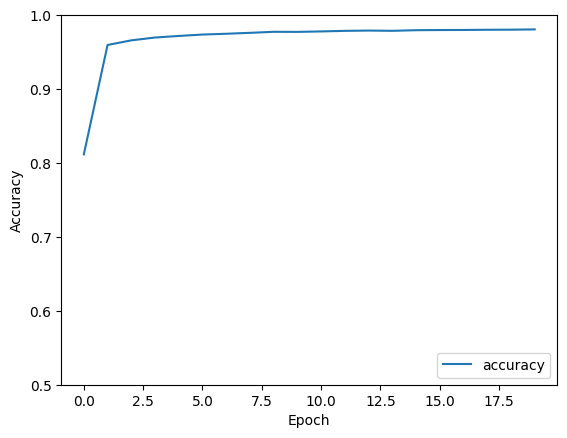

In [26]:
#checking and graphing the training accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [27]:
#benign image accuracy of the adv model
adv_model.evaluate({'feature': X_test, 'label': Y_test})

313/313 [==============================] - 59s 183ms/step - loss: 0.1870 - sparse_categorical_crossentropy: 0.0630 - sparse_categorical_accuracy: 0.9796 - scaled_adversarial_loss: 0.1240


[0.18702144920825958,
 0.06299636512994766,
 0.9796000123023987,
 0.12402498722076416]

## Attack Creation and Testing

In [29]:
#Creating the adversarial attack for adversarial training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adv(input_image, input_label, model_type = "adv_model"):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    if(model_type == "model"):
      prediction = base_model(input_image)
    else:
      prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm(input_image, input_label, eps=0.25, model_type = "adv_model"):
  perturbation = create_adv(input_image, input_label, model_type)
  adv_image = input_image + perturbation * eps
  adv_image = tf.clip_by_value(adv_image, 0, 1)

  return adv_image

def pgd(input_image, input_label, num_steps=100, eps=0.3, alpha=0.01, model_type = "adv_model"):
  adv_image = input_image
  for i in range(num_steps):
    adv_image = fgsm(adv_image, input_label, alpha, model_type)
    perturbation = adv_image - input_image
    perturbation = tf.clip_by_value(perturbation, -eps, eps)
    adv_image = input_image + perturbation
  
  return adv_image


In [39]:
#creating adv attacked dataset and testing it
adv_x = fgsm(tf.convert_to_tensor(X_test), Y_test)
adv_model.evaluate({'feature': adv_x, 'label': Y_test})

313/313 [==============================] - 53s 170ms/step - loss: 0.9757 - sparse_categorical_crossentropy: 0.2280 - sparse_categorical_accuracy: 0.9278 - scaled_adversarial_loss: 0.7477


[0.9757289886474609, 0.2280399650335312, 0.9277999997138977, 0.747688889503479]

## Model Saving

In [32]:
#saving the model so I don't have to keep training the network
adv_model.save('complete_saved_adv_pgd_40_mnist_model')

INFO:tensorflow:Assets written to: complete_saved_adv_pgd_40_mnist_model\assets


INFO:tensorflow:Assets written to: complete_saved_adv_pgd_40_mnist_model\assets


## Specific Image Testing

3


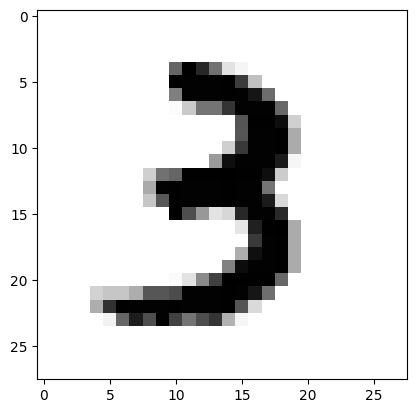

In [33]:
#shows the benign image
#allows me to test specific images
testing_index = 4983
print(Y_test[testing_index])
plottable_image = np.reshape(X_test[testing_index], (28, 28))
plt.imshow(plottable_image, cmap='gray_r')

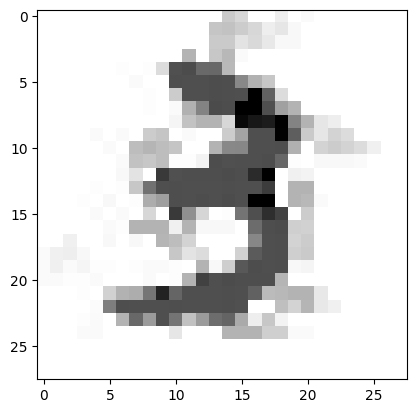

In [34]:
#shows the malignant (pgd) image
plt.figure()
plt.imshow(adv_x[testing_index]*0.5+0.5, cmap = "gray_r")

In [35]:
#base model prediction against adv attack
base_model.predict(np.expand_dims(adv_x[testing_index], axis = 0))

array([[4.7893905e-13, 9.8212700e-09, 6.3913680e-10, 9.9998820e-01,
        2.0050441e-09, 3.6609310e-06, 2.8125622e-14, 1.6243471e-06,
        1.4016815e-08, 6.4996252e-06]], dtype=float32)

In [36]:
#setting initail model's weights to adv model's weights
#Turns initial model into the Adv model
model.set_weights(adv_model.get_weights())

In [37]:
#Adv model prediction
model.predict(np.expand_dims(adv_x[testing_index], axis = 0))

array([[8.82945471e-07, 9.22453273e-06, 1.75042533e-05, 9.97778594e-01,
        2.69091906e-05, 5.58191503e-04, 3.87329955e-08, 1.34622005e-05,
        3.32747964e-04, 1.26243848e-03]], dtype=float32)